## Importing libraries

In [70]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from tensorflow.keras import layers
from time import perf_counter 
from tensorflow.keras.models import Sequential
import plotly.express as px

from keras.layers import Dense,Dropout,Flatten
from keras.layers import Conv2D,MaxPooling2D,Activation,AveragePooling2D,BatchNormalization

import os

import seaborn as sns
from IPython.display import SVG
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
print("Tf version: ", tf.__version__)

#check for gpu accessibility 
print("GPU", "Yessss Available" if tf.config.list_physical_devices("GPU")else "not Available :(")

Tf version:  2.3.1
GPU Yessss Available


In [2]:
!nvidia-smi

Thu Dec  3 09:11:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    33W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
base_dir = "../input/plantdisease/PlantVillage"

In [4]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0,
                                                             rotation_range=360,
                                                             shear_range = 0.2,
                                                             zoom_range = 0.2,
                                                             width_shift_range = 0.2,
                                                             height_shift_range = 0.2,
                                                             horizontal_flip=True,
                                                             vertical_flip=True,
                                                             validation_split = 0.2,
                                                             fill_mode="nearest")


train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.


In [5]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((64, 224, 224, 3), (64, 15))

In [6]:
Diseases = list(train_generator.class_indices.keys())
print(Diseases)

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [7]:
labels = "\n".join(sorted(train_generator.class_indices.keys()))

with open("labels.txt", "w") as f:
    f.write(labels)

In [8]:
# Number of images for each disease
nums = {}
for disease in Diseases:
    nums[disease] = len(os.listdir(base_dir + '/' + disease))
print(nums)

{'Pepper__bell___Bacterial_spot': 997, 'Pepper__bell___healthy': 1478, 'Potato___Early_blight': 1000, 'Potato___Late_blight': 1000, 'Potato___healthy': 152, 'Tomato_Bacterial_spot': 2127, 'Tomato_Early_blight': 1000, 'Tomato_Late_blight': 1909, 'Tomato_Leaf_Mold': 952, 'Tomato_Septoria_leaf_spot': 1771, 'Tomato_Spider_mites_Two_spotted_spider_mite': 1676, 'Tomato__Target_Spot': 1404, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 3209, 'Tomato__Tomato_mosaic_virus': 373, 'Tomato_healthy': 1591}


In [9]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

In [10]:
# CNN building.
model = Sequential()
model.add(Conv2D(32, (5, 5),input_shape=IMG_SHAPE,activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(32, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))   
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128,activation='relu'))          
model.add(Dense(len(Diseases),activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 71, 71, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 33, 33, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0

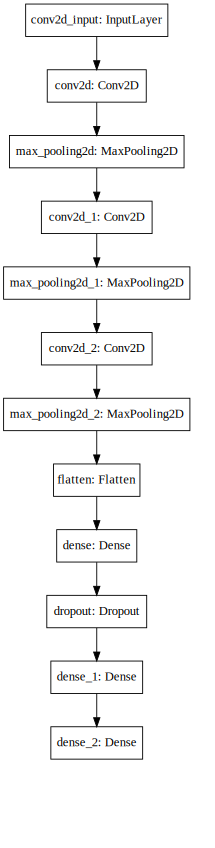

In [11]:
SVG(tf.keras.utils.model_to_dot(model, dpi=80, show_shapes=False, show_layer_names=True, rankdir='TB', expand_nested=False, subgraph=False).create(prog='dot', format='svg'))

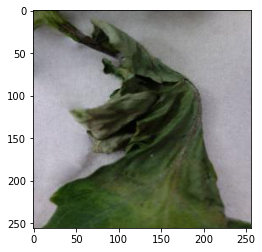

In [12]:
# Take one image to visualize it's changes after every layer
from keras.preprocessing import image
import numpy as np
img1 = image.load_img('../input/plantdisease/PlantVillage/Tomato_Late_blight/01a68044-9c5b-4658-a944-6108c6862ce7___GHLB Leaf 2.1 Day 16.JPG')
plt.imshow(img1);

#preprocess image
img1 = image.load_img('../input/plantdisease/PlantVillage/Tomato_Late_blight/01a68044-9c5b-4658-a944-6108c6862ce7___GHLB Leaf 2.1 Day 16.JPG', target_size=(IMAGE_SIZE, IMAGE_SIZE))
img = image.img_to_array(img1)
img = img/255
img = np.expand_dims(img, axis=0)

In [13]:
# Visualizing output after every layer.
from keras.models import Model
conv2d_1_output = Model(inputs=model.input, outputs=model.get_layer('conv2d').output)
max_pooling2d_1_output = Model(inputs=model.input,outputs=model.get_layer('max_pooling2d').output)
conv2d_2_output = Model(inputs=model.input,outputs=model.get_layer('conv2d_1').output)
max_pooling2d_2_output = Model(inputs=model.input,outputs=model.get_layer('max_pooling2d_1').output)
conv2d_3_output = Model(inputs=model.input,outputs=model.get_layer('conv2d_2').output)
max_pooling2d_3_output = Model(inputs=model.input,outputs=model.get_layer('max_pooling2d_2').output)
flatten_1_output = Model(inputs=model.input,outputs=model.get_layer('flatten').output)
conv2d_1_features = conv2d_1_output.predict(img)
max_pooling2d_1_features = max_pooling2d_1_output.predict(img)
conv2d_2_features = conv2d_2_output.predict(img)
max_pooling2d_2_features = max_pooling2d_2_output.predict(img)
conv2d_3_features = conv2d_3_output.predict(img)
max_pooling2d_3_features = max_pooling2d_3_output.predict(img)
flatten_1_features = flatten_1_output.predict(img)

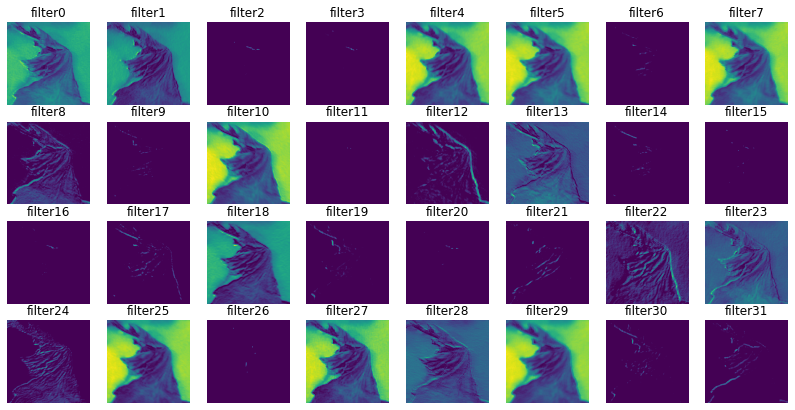

In [14]:
import matplotlib.image as mpimg

fig=plt.figure(figsize=(14,7))
columns = 8
rows = 4
for i in range(columns*rows):
    #img = mpimg.imread()
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter'+str(i))
    plt.imshow(conv2d_1_features[0, :, :, i], cmap='viridis') # Visualizing in color mode.
plt.show()

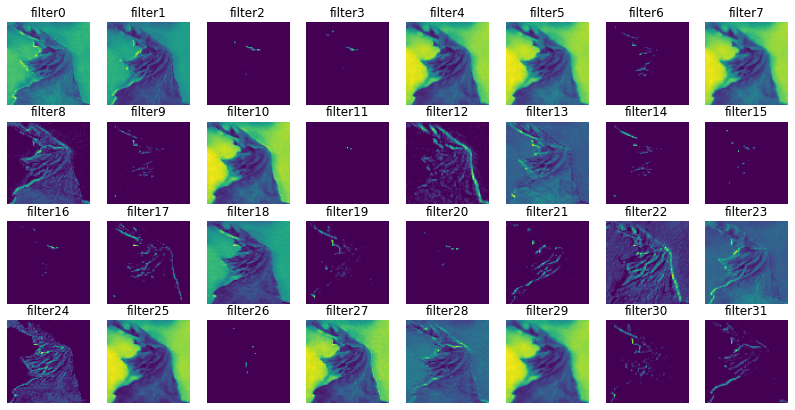

In [15]:
import matplotlib.image as mpimg

fig=plt.figure(figsize=(14,7))
columns = 8
rows = 4
for i in range(columns*rows):
    #img = mpimg.imread()
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter'+str(i))
    plt.imshow(max_pooling2d_1_features[0, :, :, i], cmap='viridis')
plt.show()

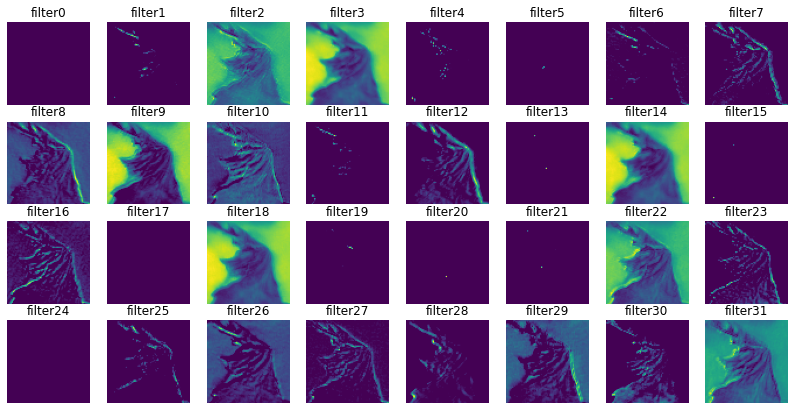

In [16]:
import matplotlib.image as mpimg

fig=plt.figure(figsize=(14,7))
columns = 8
rows = 4
for i in range(columns*rows):
    #img = mpimg.imread()
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter'+str(i))
    plt.imshow(conv2d_2_features[0, :, :, i], cmap='viridis')

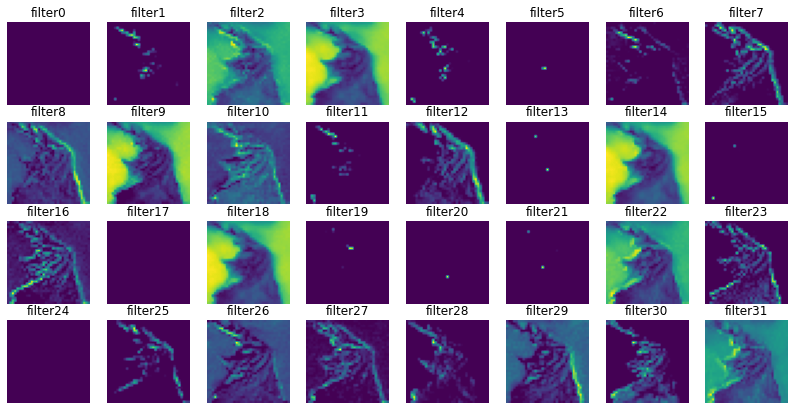

In [17]:
# we can also visualize in color mode.
import matplotlib.image as mpimg

fig=plt.figure(figsize=(14,7))
columns = 8
rows = 4
for i in range(columns*rows):
    #img = mpimg.imread()
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter'+str(i))
    plt.imshow(max_pooling2d_2_features[0, :, :, i], cmap='viridis') 
plt.show()

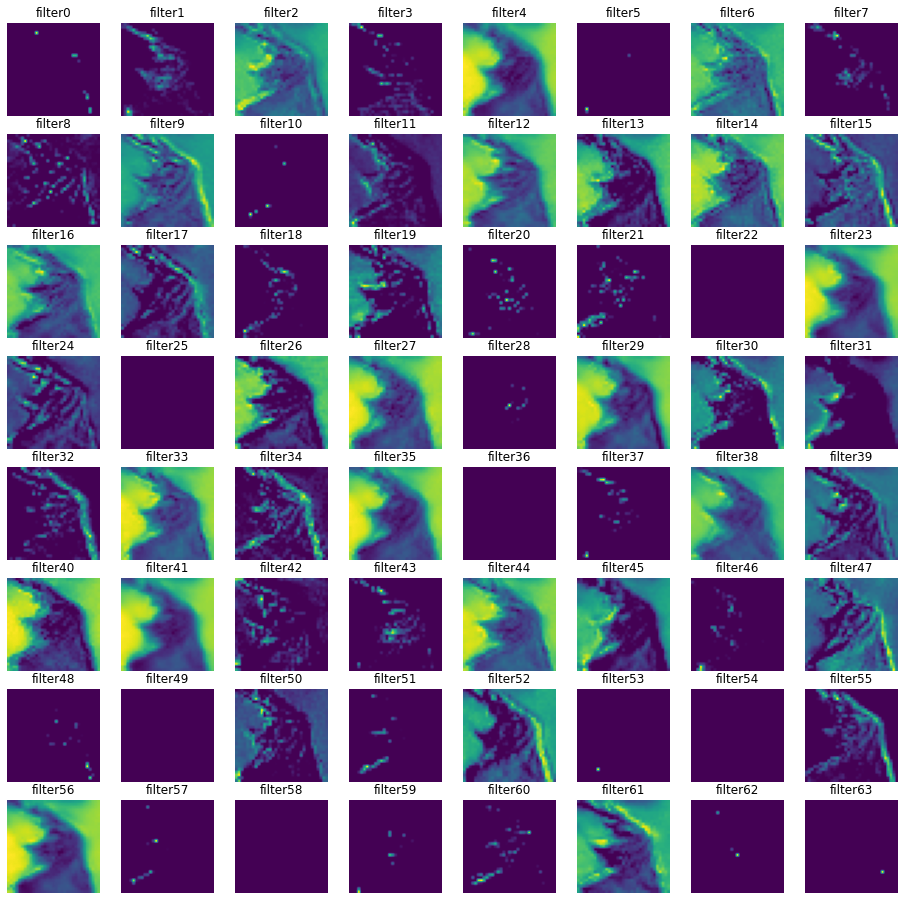

In [18]:
import matplotlib.image as mpimg

fig=plt.figure(figsize=(16,16))
columns =8 
rows = 8
for i in range(columns*rows):
    #img = mpimg.imread()
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter'+str(i))
    plt.imshow(conv2d_3_features[0, :, :, i], cmap='viridis')
plt.show()

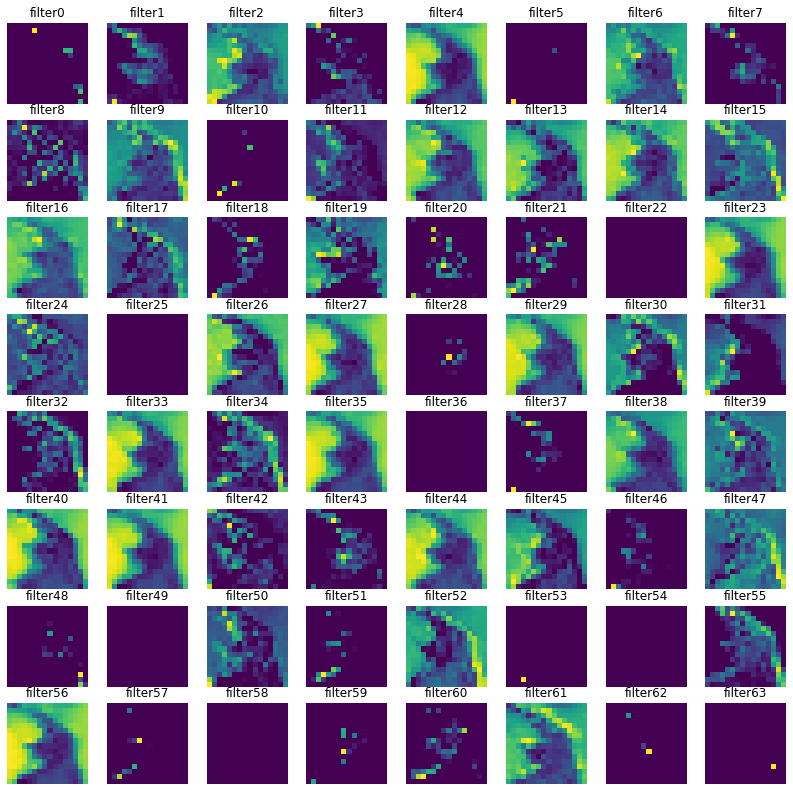

In [19]:
import matplotlib.image as mpimg

fig=plt.figure(figsize=(14,14))
columns = 8
rows = 8
for i in range(columns*rows):
    #img = mpimg.imread()
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter'+str(i))
    plt.imshow(max_pooling2d_3_features[0, :, :, i],cmap='viridis')
plt.show()

In [20]:
# Create early stopping (once our model stops improving, stop training)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=5) # stops after 5 rounds of no improvements

In [21]:
def plot_history_loss(model):
    fig = px.line(
          model.history, y=['loss', 'val_loss'],
          labels={'index': 'epoch', 'value': 'loss'}, 
          title='Training History')
    fig.show()

In [22]:
def plot_history_accuracy(model):
    fig = px.line(
          model.history, y=['accuracy', 'val_accuracy'],
          labels={'index': 'epoch', 'value': 'accuracy'}, 
          title='Training History')
    fig.show()
    

In [23]:
def model_evaluation(model):
    loss, acc = model.evaluate(val_generator,verbose=0)
    print('Test loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(acc))

In [24]:
# Model building to get trained with parameters.
opt=keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
train=model.fit(train_generator,
                 epochs=50,
                 steps_per_epoch=train_generator.samples // BATCH_SIZE,
                 validation_data=val_generator,
                 validation_steps= val_generator.samples// BATCH_SIZE,verbose=1,
                 callbacks = early_stopping)

Epoch 1/50
258/258 [==============================] - 344s 1s/step - loss: 1.7760 - accuracy: 0.4246 - val_loss: 1.1262 - val_accuracy: 0.6277
Epoch 2/50
258/258 [==============================] - 297s 1s/step - loss: 1.1027 - accuracy: 0.6275 - val_loss: 0.8465 - val_accuracy: 0.7109
Epoch 3/50
258/258 [==============================] - 299s 1s/step - loss: 0.8691 - accuracy: 0.7052 - val_loss: 0.7859 - val_accuracy: 0.7192
Epoch 4/50
258/258 [==============================] - 298s 1s/step - loss: 0.7418 - accuracy: 0.7457 - val_loss: 0.5673 - val_accuracy: 0.8022
Epoch 5/50
258/258 [==============================] - 297s 1s/step - loss: 0.6521 - accuracy: 0.7763 - val_loss: 0.5517 - val_accuracy: 0.8108
Epoch 6/50
258/258 [==============================] - 293s 1s/step - loss: 0.5749 - accuracy: 0.8046 - val_loss: 0.5055 - val_accuracy: 0.8274
Epoch 7/50
258/258 [==============================] - 298s 1s/step - loss: 0.5340 - accuracy: 0.8156 - val_loss: 0.4360 - val_accuracy: 0.8420

In [25]:
model_evaluation(model)

Test loss: 0.1611337661743164
Test Accuracy: 0.9468704462051392


In [26]:
plot_history_loss(train)

In [27]:
plot_history_accuracy(train)

In [28]:
model.save('train_cnn.h5')

In [80]:
model = tf.keras.models.load_model('train_cnn.h5')

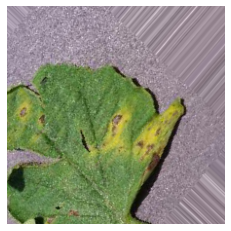

True label: Tomato_Septoria_leaf_spot
Predicted label: Tomato_Septoria_leaf_spot


In [30]:
def get_class_string_from_index(index):
   for class_string, class_index in val_generator.class_indices.items():
      if class_index == index:
         return class_string

x, y = next(val_generator)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))

In [31]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_float_model = converter.convert()

# Show model size in KBs.
float_model_size = len(tflite_float_model) / 1024
print('Float model size = %dKBs.' % float_model_size)

Float model size = 33155KBs.


In [32]:
# Re-convert the model to TF Lite using quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Show model size in KBs.
quantized_model_size = len(tflite_quantized_model) / 1024
print('Quantized model size = %dKBs,' % quantized_model_size)
print('which is about %d%% of the float model size.'\
      % (quantized_model_size * 100 / float_model_size))

Quantized model size = 8294KBs,
which is about 25% of the float model size.


In [33]:
f = open('model.tflite', "wb")
f.write(tflite_quantized_model)
f.close()

In [34]:
base_model = keras.applications.MobileNetV2(weights="imagenet",include_top=False,input_shape=IMG_SHAPE)

9412608/9406464 [==============================] - 0s 0us/step


In [35]:
base_model.trainable = False
inputs = keras.Input(shape=IMG_SHAPE)
x = base_model(inputs,training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(len(Diseases),activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=x, name="MobileNetV2")

In [36]:
model.summary()

Model: "MobileNetV2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 15)                19215     
Total params: 2,277,199
Trainable params: 19,215
Non-trainable params: 2,257,984
_________________________________________________________________


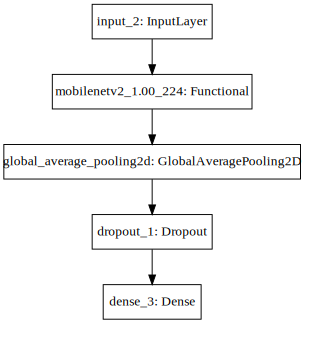

In [37]:
SVG(tf.keras.utils.model_to_dot(model, dpi=75, show_shapes=False, show_layer_names=True, rankdir='TB', expand_nested=False, subgraph=False).create(prog='dot', format='svg'))

In [38]:
model.compile(optimizer='sgd',loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), metrics=['accuracy'])
# Create early stopping (once our model stops improving, stop training)

In [39]:
# lets train our CNN
MobileNetv2 = model.fit(train_generator,
                   validation_data= val_generator,
                   epochs = 50,
                   steps_per_epoch=train_generator.samples // BATCH_SIZE,
                   validation_steps = val_generator.samples// BATCH_SIZE,verbose=1,
                   callbacks=early_stopping)

Epoch 1/50
258/258 [==============================] - 272s 1s/step - loss: 1.8464 - accuracy: 0.4916 - val_loss: 1.3924 - val_accuracy: 0.6855
Epoch 2/50
258/258 [==============================] - 272s 1s/step - loss: 1.4026 - accuracy: 0.6746 - val_loss: 1.2528 - val_accuracy: 0.7397
Epoch 3/50
258/258 [==============================] - 270s 1s/step - loss: 1.3025 - accuracy: 0.7204 - val_loss: 1.1805 - val_accuracy: 0.7742
Epoch 4/50
258/258 [==============================] - 271s 1s/step - loss: 1.2507 - accuracy: 0.7389 - val_loss: 1.1441 - val_accuracy: 0.7971
Epoch 5/50
258/258 [==============================] - 270s 1s/step - loss: 1.2185 - accuracy: 0.7557 - val_loss: 1.1287 - val_accuracy: 0.7971
Epoch 6/50
258/258 [==============================] - 267s 1s/step - loss: 1.1927 - accuracy: 0.7699 - val_loss: 1.1020 - val_accuracy: 0.8081
Epoch 7/50
258/258 [==============================] - 266s 1s/step - loss: 1.1771 - accuracy: 0.7736 - val_loss: 1.0856 - val_accuracy: 0.8186

In [40]:
model_evaluation(model)

Test loss: 1.0142474174499512
Test Accuracy: 0.8544396162033081


In [41]:
plot_history_loss(MobileNetv2)

In [42]:
plot_history_accuracy(train)

In [43]:
model.save('mobileNetv2.h5')

In [44]:
model = tf.keras.models.load_model('mobileNetv2.h5')

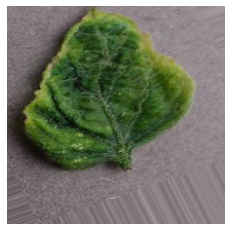

True label: Tomato__Tomato_YellowLeaf__Curl_Virus
Predicted label: Tomato__Tomato_YellowLeaf__Curl_Virus


In [45]:
x, y = next(val_generator)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()
# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))

In [46]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_float_model = converter.convert()

# Show model size in KBs.
float_model_size = len(tflite_float_model) / 1024
print('Float model size = %dKBs.' % float_model_size)

Float model size = 8736KBs.


In [47]:
# Re-convert the model to TF Lite using quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Show model size in KBs.
quantized_model_size = len(tflite_quantized_model) / 1024
print('Quantized model size = %dKBs,' % quantized_model_size)
print('which is about %d%% of the float model size.'\
      % (quantized_model_size * 100 / float_model_size))

Quantized model size = 2279KBs,
which is about 26% of the float model size.


In [48]:
f = open('mobilenetv2.tflite', "wb")
f.write(tflite_quantized_model)
f.close()

In [49]:
base_model = tf.keras.applications.InceptionResNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

219062272/219055592 [==============================] - 5s 0us/step


In [50]:
base_model.trainable = False
inputs = keras.Input(shape=IMG_SHAPE)
x = base_model(inputs,training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(len(Diseases),activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=x, name="InceptionResNetV2")

In [51]:
model.summary()

Model: "InceptionResNetV2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 15)                23055     
Total params: 54,359,791
Trainable params: 23,055
Non-trainable params: 54,336,736
_________________________________________________________________


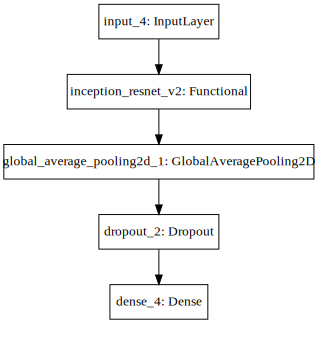

In [52]:
SVG(tf.keras.utils.model_to_dot(model, dpi=75, show_shapes=False, show_layer_names=True, rankdir='TB', expand_nested=False, subgraph=False).create(prog='dot', format='svg'))

In [53]:
model.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.5, from_logits = True), metrics=['accuracy'])
# Create early stopping (once our model stops improving, stop training)

In [54]:
# lets train our CNN
InceptionResNetV2 = model.fit(train_generator,
                   validation_data= val_generator,
                   epochs = 50,
                   steps_per_epoch=train_generator.samples // BATCH_SIZE,
                   validation_steps = val_generator.samples// BATCH_SIZE,verbose=1,
                   callbacks=early_stopping)

Epoch 1/50
258/258 [==============================] - 329s 1s/step - loss: 2.5650 - accuracy: 0.4475 - val_loss: 2.5094 - val_accuracy: 0.5632
Epoch 2/50
258/258 [==============================] - 326s 1s/step - loss: 2.5080 - accuracy: 0.5604 - val_loss: 2.4961 - val_accuracy: 0.5864
Epoch 3/50
258/258 [==============================] - 323s 1s/step - loss: 2.4960 - accuracy: 0.5826 - val_loss: 2.4872 - val_accuracy: 0.5999
Epoch 4/50
258/258 [==============================] - 326s 1s/step - loss: 2.4912 - accuracy: 0.5897 - val_loss: 2.4838 - val_accuracy: 0.6077
Epoch 5/50
258/258 [==============================] - 330s 1s/step - loss: 2.4886 - accuracy: 0.5927 - val_loss: 2.4828 - val_accuracy: 0.6074
Epoch 6/50
258/258 [==============================] - 321s 1s/step - loss: 2.4847 - accuracy: 0.6018 - val_loss: 2.4802 - val_accuracy: 0.6113
Epoch 7/50
258/258 [==============================] - 321s 1s/step - loss: 2.4836 - accuracy: 0.6019 - val_loss: 2.4773 - val_accuracy: 0.6155

In [55]:
model_evaluation(model)

Test loss: 2.4243361949920654
Test Accuracy: 0.7197962403297424


In [56]:
plot_history_loss(InceptionResNetV2)

In [57]:
plot_history_accuracy(InceptionResNetV2)

In [58]:
model.save('InceptionResNetV2.h5')

In [59]:
model = tf.keras.models.load_model('InceptionResNetV2.h5')

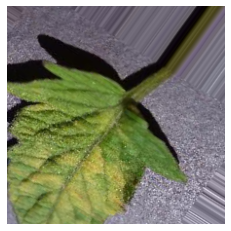

True label: Tomato_Leaf_Mold
Predicted label: Tomato_Late_blight


In [60]:
x, y = next(val_generator)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()
# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))

In [67]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_float_model = converter.convert()

# Show model size in KBs.
float_model_size = len(tflite_float_model) / 1024
print('Float model size = %dKBs.' % float_model_size)

Float model size = 212297KBs.


In [68]:
# Re-convert the model to TF Lite using quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Show model size in KBs.
quantized_model_size = len(tflite_quantized_model) / 1024
print('Quantized model size = %dKBs,' % quantized_model_size)
print('which is about %d%% of the float model size.'\
      % (quantized_model_size * 100 / float_model_size))

Quantized model size = 53458KBs,
which is about 25% of the float model size.


In [69]:
f = open('InceptionResNetV2.tflite', "wb")
f.write(tflite_quantized_model)
f.close()